In [1]:
import os.path as osp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from termcolor import colored
from changeit3d.in_out.basics import files_in_subdirs, read_saved_args, unpickle_data
from changeit3d.in_out.pointcloud import pc_loader_from_npz
from changeit3d.utils.visualization import visualize_point_clouds_3d_v2


blue = lambda x: colored(x, "blue")
red = lambda x: colored(x, "red")

In [2]:
def load_relevant_evaluation_data(pkl_file, return_recons=False, random_seed=2022):
    "Select most interesting *saved* evaluation results from pretrained networks trained with scripts/train_change_it_3d.py"    
    saved_data = next(unpickle_data(pkl_file))
    
    relevant_data = [np.round(saved_data['Chamfer_all_pairs_average'],3),
                    np.round(saved_data['lgd_averages']['without_parts_average'],3),        
                    (saved_data['LAB_avg'] * 100).round(1), 
                    np.round((saved_data['Class-Distortion (all classes, average)'] * 100),1),
                    saved_data['FPD (all classes, average)'].round(1)]
    
    if return_recons:
        reconstruction_file = osp.join(osp.dirname(pkl_file), 'evaluation_outputs.pkl')
        recons = next(unpickle_data(reconstruction_file))
        gt_input_files = recons['gt_input_pc_files']        
        npc_points = recons['transformed_shapes'][0].shape[0]
        recons['gt_input'] = [pc_loader_from_npz(x, n_samples=npc_points, random_seed=random_seed) for x in gt_input_files]
        relevant_data.append(recons)
                
    return relevant_data

In [3]:
report_backbone = "pcae"
report_backbone = "sgf" # choose from "pcae" or "sgf"

## these models are included in our downloadable networks/weights update the top directory
top_data_directory = '/home/panos/Git_Repos/changeit3d/changeit3d/data'

if report_backbone == "pcae":
    common_top_dir = osp.join(top_data_directory, 'pretrained/changers/pcae_based')
        
if report_backbone == "sgf":
    common_top_dir = osp.join(top_data_directory, 'pretrained/changers/sgf_based')
    
all_saved_models = [f for f in files_in_subdirs(common_top_dir, 'best_model.pt')]
all_model_dirs = [osp.dirname(f) for f in all_saved_models]
print(f'N-models found: {len(all_saved_models)}')

experiment_tag = "results/evaluation_metric_results.pkl"

# UNCOMMENT for nearest neighbors baseline
# experiment_tag = "results_with_nearest_neighb_baseline/evaluation_metric_results.pkl"  

# collect_relevant_files:  
result_files = [osp.join(common_top_dir,  trail, experiment_tag) for trail in all_model_dirs]
result_files = [r for r in result_files if osp.exists(r)]
print(f'Relevant evaluation saved files found: {len(result_files)}')

N-models found: 20
Relevant evaluation saved files found: 20


In [4]:
compute_also_nn = False
load_reconstructions = True  # for SGF we saved the reconstructions during the evaluation since it takes a while to recompute them
reconstructions = dict()
aggregate_results = list()

for r in result_files:
    c = r.replace(experiment_tag, 'config.json.txt')     # configuration
    config = read_saved_args(c)
    info = [config.identity_penalty, config.self_contrast, config.shape_editor_variant]
    data = load_relevant_evaluation_data(r, load_reconstructions)
    
    if load_reconstructions:
        reconstructions['_'.join([str(i) for i in info])] = data[-1]
        data = data[:-1]                        
    
    aggregate_results.append(info + data)
    
    if compute_also_nn:
        r = r.replace(osp.basename(r), 'evaluation_metric_results_for_retrieval.pkl')    # retrieval alternative
        data = load_relevant_evaluation_data(r)
        info[2] = info[2]+" (NN)"
        aggregate_results.append(info + data)
        
aggregate_results = pd.DataFrame(aggregate_results)
aggregate_results.columns = ['identity_penalty', 'self_contrast', 'shape_editor_variant', 'Chamfer',  'LGD',  'LAB', 'CD', 'FPD']

In [5]:
# restrict to specific hyper-parameters
if False:
    # aggregate_results = aggregate_results[aggregate_results.identity_penalty == 0.05]
    aggregate_results = aggregate_results[aggregate_results.self_contrast == True]
    aggregate_results.reset_index(inplace=True, drop=True)

In [6]:
aggregate_results = pd.concat([aggregate_results])

for id_pen in sorted(aggregate_results.identity_penalty.unique()):
    aggregate_results_sub = aggregate_results[aggregate_results.identity_penalty == id_pen].copy()
    aggregate_results_sub.reset_index(inplace=True, drop=True)
    print(aggregate_results_sub.sort_values(['shape_editor_variant', 'self_contrast']).to_string())

   identity_penalty  self_contrast      shape_editor_variant  Chamfer    LGD   LAB   CD   FPD
2              0.01          False                   coupled    0.779  1.863  70.2  7.5  76.7
3              0.01           True                   coupled    0.409  0.899  64.0  5.2  26.1
0              0.01          False  decoupling_mag_direction    0.698  1.653  71.3  8.3  54.1
1              0.01           True  decoupling_mag_direction    0.413  0.938  64.1  5.4  25.7
   identity_penalty  self_contrast      shape_editor_variant  Chamfer    LGD   LAB   CD   FPD
2             0.025          False                   coupled    0.561  1.209  70.1  6.4  37.8
3             0.025           True                   coupled    0.343  0.715  61.0  4.3  19.0
0             0.025          False  decoupling_mag_direction    0.577  1.378  71.0  6.5  39.1
1             0.025           True  decoupling_mag_direction    0.332  0.796  60.6  4.2  18.2
   identity_penalty  self_contrast      shape_editor_variant

the legs are thin -er


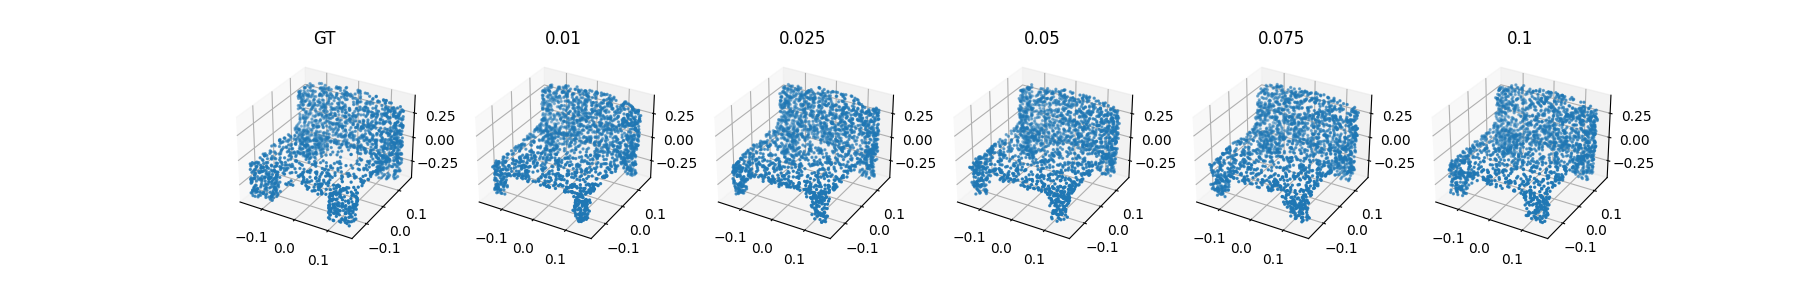

In [39]:
n_shapes = reconstructions[list(reconstructions.keys())[0]]['transformed_shapes'][0].shape[0]
ridx = np.random.choice(n_shapes)

pc_compared = []
ablation_names = []
lang = None 
ablation_to_check_tag = '_True_decoupling_mag_direction'
for idp in sorted(aggregate_results.identity_penalty.unique()):    
    ablation = f'{idp}' + ablation_to_check_tag
    ablation_names.append(str(idp))
    
    pc_compared.append(reconstructions[ablation]['transformed_shapes'][ridx])    
    if lang is None:
        lang = reconstructions[ablation]['language_used'][ridx]
        gt_input = reconstructions[ablation]['gt_input'][ridx]
        pc_compared.insert(0, gt_input)
    else:
        assert lang == reconstructions[ablation]['language_used'][ridx]
        assert np.all(gt_input == reconstructions[ablation]['gt_input'][ridx])

print(lang)
visualize_point_clouds_3d_v2(pc_compared, title_lst= ['GT'] + ablation_names, vis_axis_order=[0, 2, 1])

In [8]:
# Comparing architectures ("shape_editor_variant" ablations)

lower_is_better = ['Chamfer', 'LGD', 'CD', 'FPD']
higher_is_better = ['LAB']

# over self-contrast, identity-penalty, coupling or not, for each metric independently
for metric in lower_is_better:
    loc = aggregate_results[metric].argmin()
    print(metric, red(aggregate_results.loc[loc]['shape_editor_variant']), (aggregate_results.loc[loc]['identity_penalty'], aggregate_results.loc[loc]['self_contrast']))
for metric in higher_is_better:
    loc = aggregate_results[metric].argmax()    
    print(metric, red(aggregate_results.loc[loc]['shape_editor_variant']), (aggregate_results.loc[loc]['identity_penalty'], aggregate_results.loc[loc]['self_contrast']))

Chamfer decoupling_mag_direction (0.1, True)
LGD coupled (0.075, True)
CD decoupling_mag_direction (0.1, True)
FPD decoupling_mag_direction (0.1, True)
LAB decoupling_mag_direction (0.01, False)


total variations 5


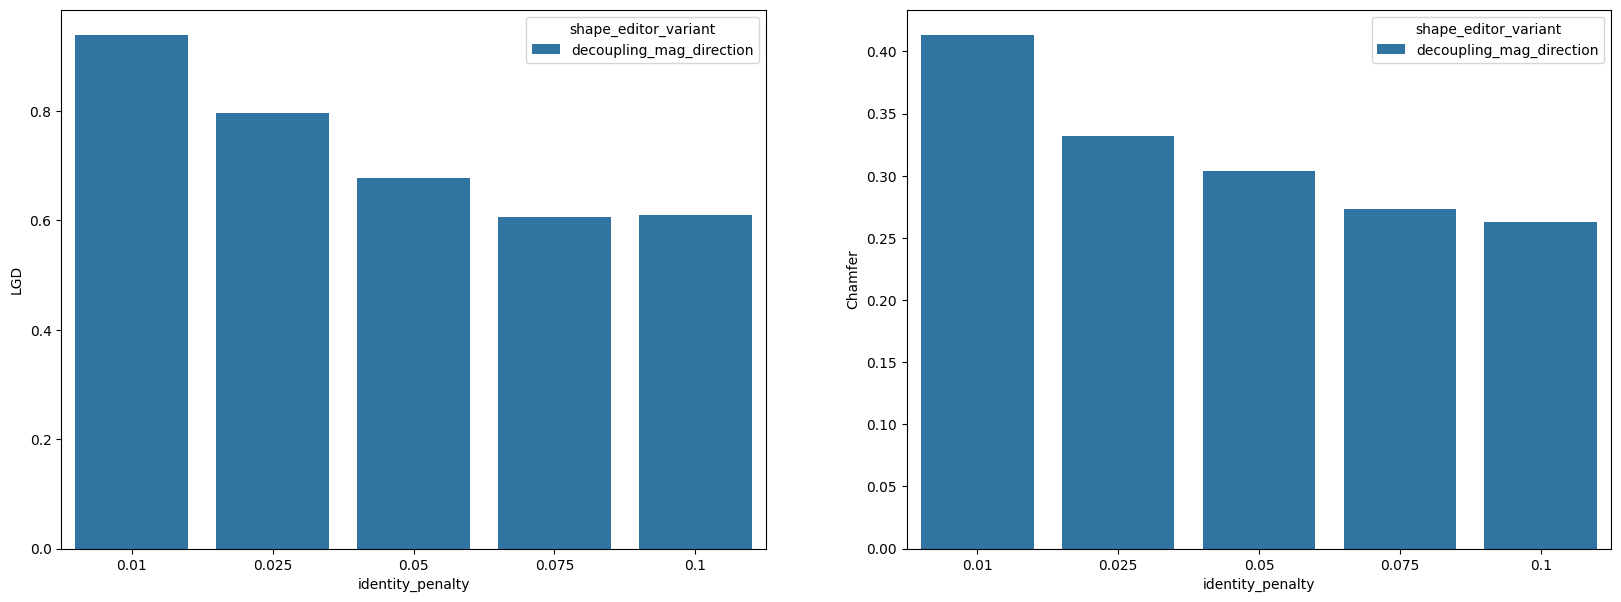

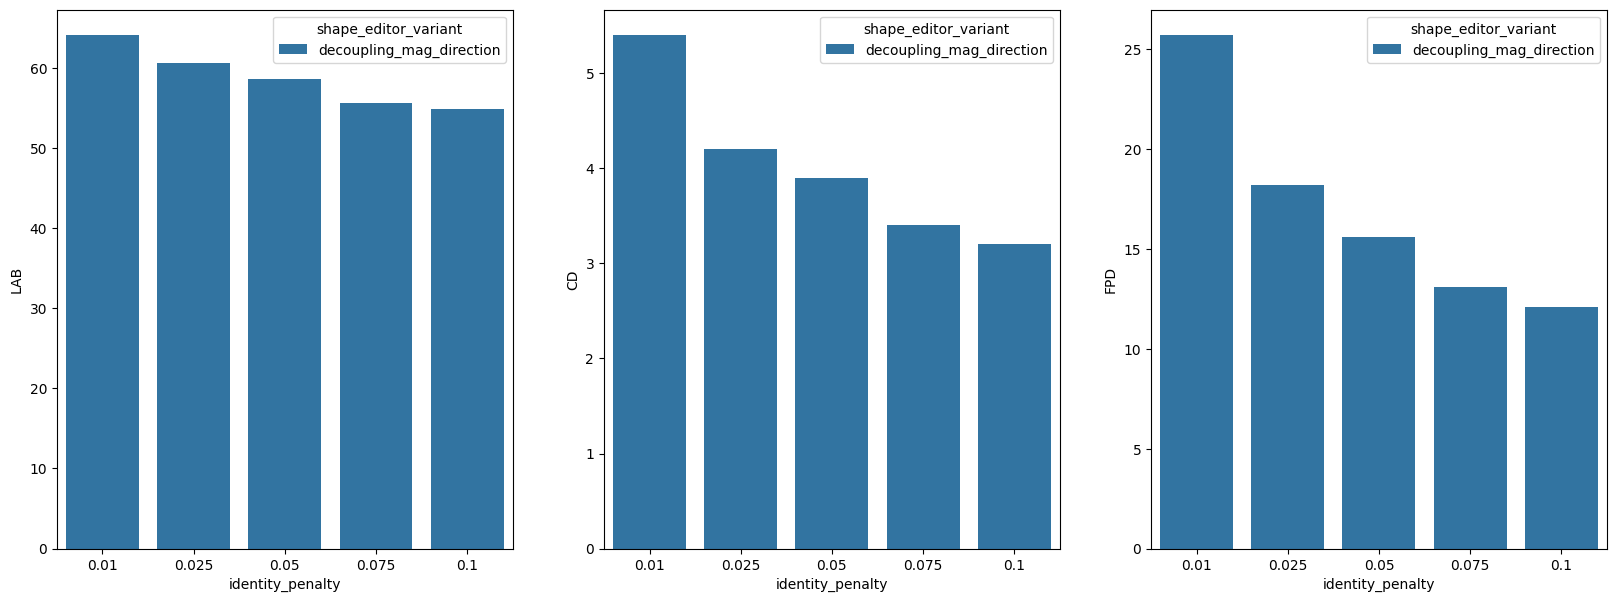

In [11]:
possible_restrictions_on_ablations =\
    {'shape_editor_variant': ['decoupling_mag_direction'], 
     'self_contrast': [True],
     'identity_penalty': None
    }
    
mask = np.ones(len(aggregate_results), dtype=bool)
for quantity, restriction in  possible_restrictions_on_ablations.items():
    if restriction is not None:
        mask &= aggregate_results[quantity].isin(restriction)

print('total variations', sum(mask))

ndf = aggregate_results[mask]
ndf.reset_index(inplace=True)

y_axis_metrics = [['LGD', 'Chamfer'], ['LAB', 'CD', 'FPD']]

for metrics in y_axis_metrics:
    fig, axs = plt.subplots(1, len(metrics), figsize=(20, 7))
    
    for i, y in enumerate(metrics):
        sns.barplot(x="identity_penalty",
                    y=y,
                    hue="shape_editor_variant",                    
                    data=ndf, 
                    ax=axs[i])